# Imports

In [ ]:
!pip install datasets

In [ ]:
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import matplotlib.image as mpimg
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [ ]:
dataset = load_dataset("mstz/compas", "two-years-recidividity")["train"]

# Data Visualization

In [ ]:
df = dataset.to_pandas()
df.head()

,is_male,age,race,number_of_juvenile_fellonies,decile_score,number_of_juvenile_misdemeanors,number_of_other_juvenile_offenses,number_of_prior_offenses,days_before_screening_arrest,is_recidivous,days_in_custody,is_violent_recidivous,violence_decile_score,two_year_recidivous
0,True,69,Other,0,1,0,0,0,-1,False,7,False,1,0
1,True,34,African-American,0,3,0,0,0,-1,True,10,True,1,1
2,True,44,Other,0,1,0,0,0,0,False,1,False,1,0
3,True,43,Other,0,4,0,0,3,-1,False,12,False,3,0
4,False,39,Caucasian,0,1,0,0,0,-1,False,3,False,1,0


In [ ]:
print(df.describe())

               age  number_of_juvenile_fellonies  decile_score  \
count  4534.000000                   4534.000000   4534.000000   
mean     35.919056                      0.046096      3.975959   
std      12.169380                      0.428256      2.748378   
min      18.000000                      0.000000     -1.000000   
25%      26.000000                      0.000000      1.000000   
50%      33.000000                      0.000000      3.000000   
75%      44.000000                      0.000000      6.000000   
max      83.000000                     20.000000     10.000000   

       number_of_juvenile_misdemeanors  number_of_other_juvenile_offenses  \
count                       4534.00000                        4534.000000   
mean                           0.07124                           0.081165   
std                            0.40892                           0.470655   
min                            0.00000                           0.000000   
25%                 

**Age distribution**

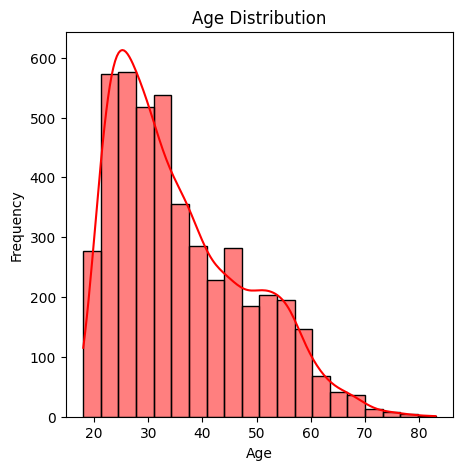

In [ ]:
plt.figure(figsize=(5, 5))
sns.histplot(df['age'], bins=20, kde=True, color='red')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

**Sex Distribution**

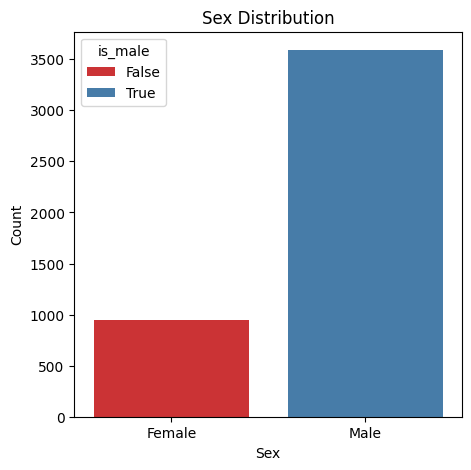

In [ ]:
plt.figure(figsize=(5, 5))
sns.countplot(data=df, x='is_male', hue='is_male', palette="Set1")
plt.xticks([0, 1], ['Female', 'Male'])
plt.title('Sex Distribution')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.show()

**Ethnic Distribution**

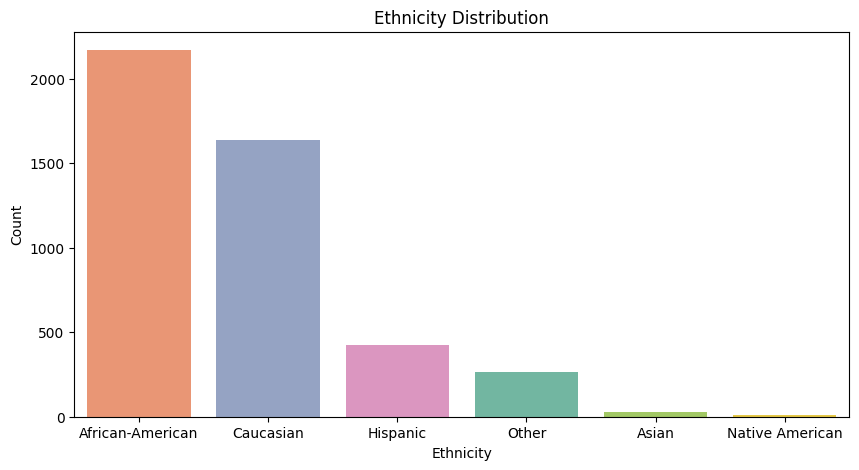

In [ ]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='race', hue='race', order=df['race'].value_counts().index, palette="Set2")
plt.title('Ethnicity Distribution')
plt.xlabel('Ethnicity')
plt.ylabel('Count')
plt.show()

**Ethnicity vs Age**

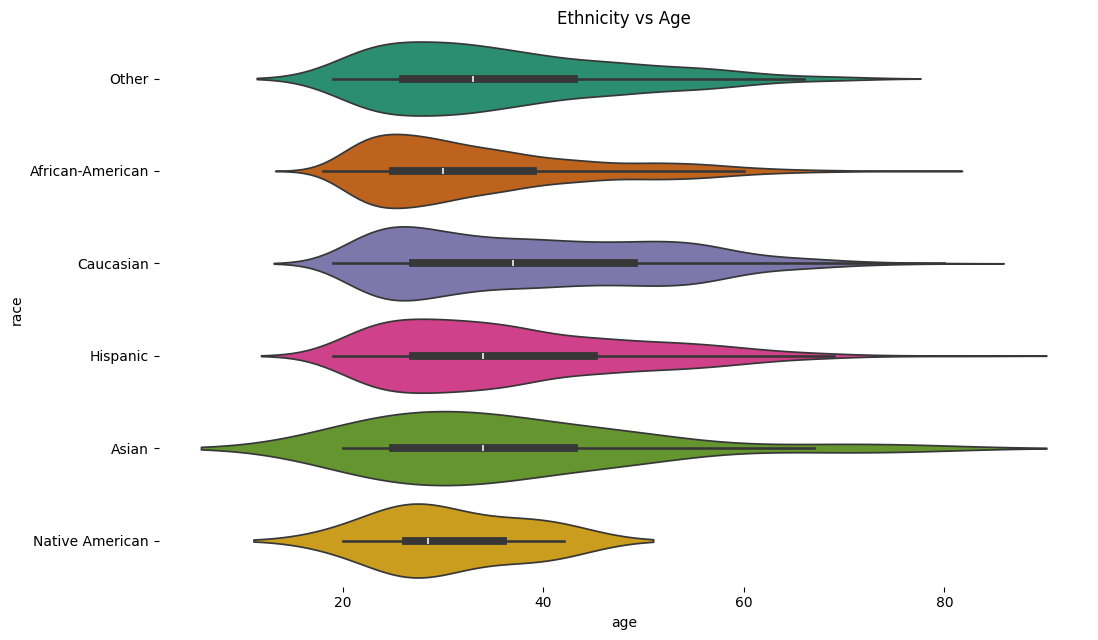

In [ ]:
figsize = (12, 1.2 * len(df['race'].unique()))
plt.figure(figsize=figsize)
plt.title('Ethnicity vs Age')
sns.violinplot(df, x='age', y='race', hue='race', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

# Prediction Models with ethnicity

*Initialization and helper functions*

In [ ]:
features = ['age', 'is_male', 'race', 'number_of_juvenile_fellonies', 'number_of_juvenile_misdemeanors', 'number_of_other_juvenile_offenses', 'number_of_prior_offenses']
target = ['is_recidivous']

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
encoder = LabelEncoder()

X_train['race'] = encoder.fit_transform(X_train['race'])
X_test['race'] = encoder.fit_transform(X_test['race'])

smote = SMOTE(sampling_strategy='minority', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [ ]:
def plot_confusion_matrix(y_test, y_pred, cmap):
  conf_matrix = confusion_matrix(y_test, y_pred)
  plt.figure(figsize=(6,5))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=cmap, xticklabels=['No recidivous', 'recidivous'],
              yticklabels=['No recidivous', 'recidivous'])
  plt.title('Confusion Matrix')
  plt.ylabel('Real values')
  plt.xlabel('Predictions')
  plt.show()

In [ ]:
def plot_roc_curve(y_test, y_pred_proba, c):
    """Plot the ROC curve for a given model specified by c."""
    # Calculate false positive rate, true positive rate, and thresholds
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    model_config = {
        1: ("ROC Curve - Tree Classifier", "Tomato"),
        2: ("ROC Curve - Random Forest", "royalblue"),
        3: ("ROC Curve - XGBoost", "green"),
        4: ("ROC Curve - Random Forest (Custom)", "purple"),
    }
    # Get the title and color for the specified model
    title, color = model_config.get(c, ("ROC Curve", "black"))
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}', color=color)
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.title(title)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()


*Decision Tree*

In [ ]:
clf_tree = DecisionTreeClassifier(max_depth=3, random_state=42)
clf_tree.fit(X_resampled, y_resampled)
y_pred_tree = clf_tree.predict(X_test)

In [ ]:
accuracy_tree = accuracy_score(y_test, y_pred_tree)
print(f'Decision tree accuracy: {accuracy_tree:.2f}')

Decision tree accuracy: 0.73


In [ ]:
print(f'Classification report: \n {classification_report(y_test, y_pred_tree)}')

Classification report: 
               precision    recall  f1-score   support

       False       0.85      0.79      0.82      1054
        True       0.43      0.53      0.47       307

    accuracy                           0.73      1361
   macro avg       0.64      0.66      0.65      1361
weighted avg       0.76      0.73      0.74      1361



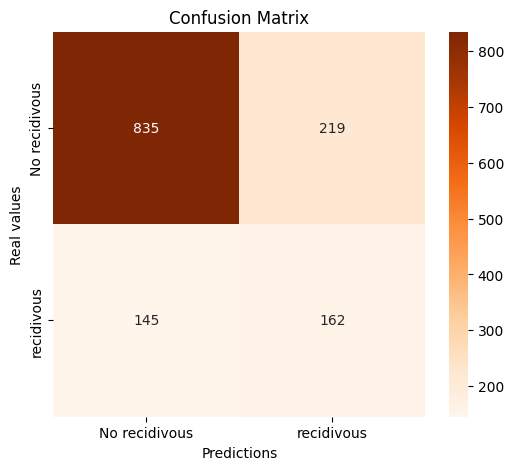

In [ ]:
plot_confusion_matrix(y_test, y_pred_tree, 'Oranges')

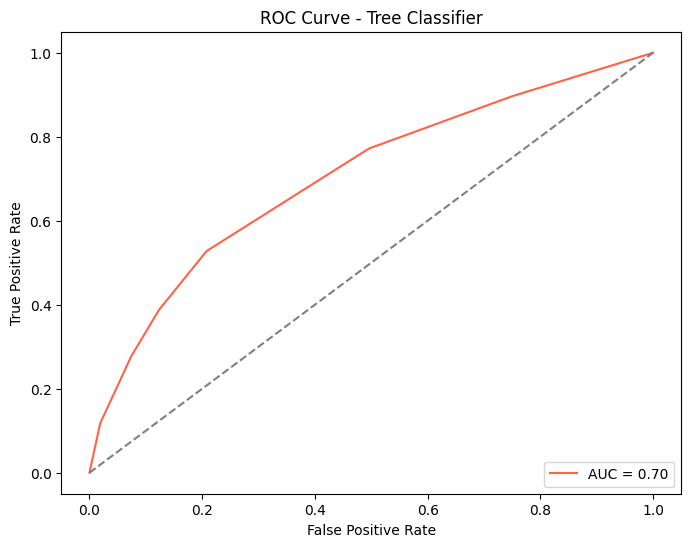

In [ ]:
y_pred_proba = clf_tree.predict_proba(X_test)[:, 1]
plot_roc_curve(y_test, y_pred_proba, 1)

I tackled the class imbalance issue by applying the Synthetic Minority Oversampling Technique (SMOTE), focusing on a 'minority' sampling strategy. After resampling, I trained a Decision Tree classifier with a maximum depth of 3 to keep things simple. The model hit an accuracy of 73% on the test set, meaning it correctly predicted recidivism or non-recidivism in about three out of four cases.

The classification report offers a deeper dive into the model's performance:

For the non-recidivism class (False), the model scored a precision of 0.85 and a recall of 0.79, showing it’s pretty solid at identifying non-recidivism cases.
For the recidivism class (True), the precision was 0.43 and the recall 0.53, indicating the model has a tougher time correctly identifying recidivism cases. This could be due to lingering class imbalance or the model's limitations.
The confusion matrix lays out the true positive, true negative, false positive, and false negative rates, highlighting that the model is better at predicting non-recidivism than recidivism.

An AUC score of 0.70 suggests the model has some predictive power but isn't highly accurate in distinguishing between the two classes. This aligns with the classification report, where the model excelled with non-recidivism cases but struggled to accurately predict recidivism.

*Random Forest*

In [ ]:
rf = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42, max_leaf_nodes=35)
rf.fit(X_resampled, y_resampled)
y_pred_rf = rf.predict(X_test)

In [ ]:
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'Random forest accuracy: {accuracy_rf:.2f}')

Random forest accuracy: 0.69


In [ ]:
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

Classification Report:
               precision    recall  f1-score   support

       False       0.87      0.71      0.78      1054
        True       0.39      0.64      0.49       307

    accuracy                           0.69      1361
   macro avg       0.63      0.68      0.63      1361
weighted avg       0.76      0.69      0.72      1361



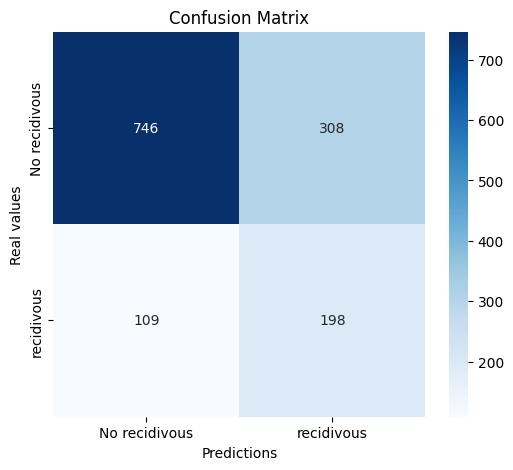

In [ ]:
plot_confusion_matrix(y_test, y_pred_rf, 'Blues')

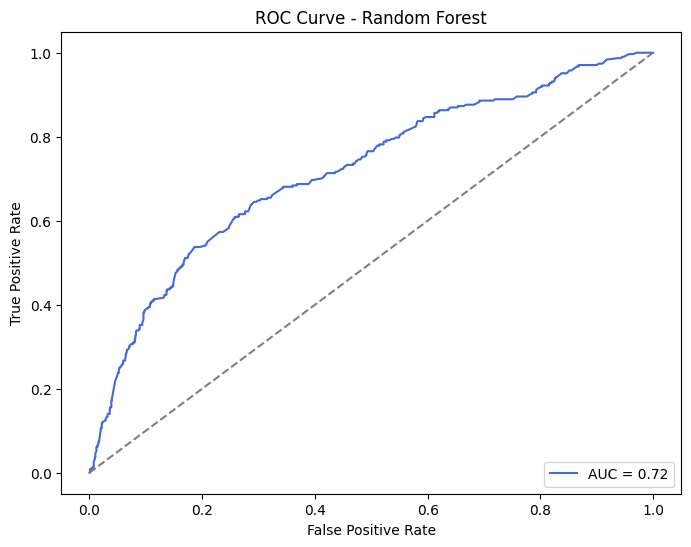

In [ ]:
y_pred_proba = rf.predict_proba(X_test)[:, 1]
plot_roc_curve(y_test, y_pred_proba, 2)

I trained a Random Forest classifier with 100 estimators, a maximum depth of 3, and a maximum of 35 leaf nodes to strike a balance between model complexity and interpretability. After putting it through its paces with the resampled data, the model hit an accuracy of 69% on the test set, just a tad below what the Decision Tree model achieved.

Diving into the classification report, here’s what I found:

For the non-recidivism class (False), the model nailed a precision of 0.87 and a recall of 0.71, showing it’s pretty good at spotting cases of non-recidivism.
For the recidivism class (True), the precision came in at 0.39, and the recall at 0.64. This means the model catches a decent number of actual recidivism cases but still struggles with a high false positive rate.
The confusion matrix backs this up, revealing a clear imbalance in accurately predicting recidivism cases.

The model’s AUC score of 0.72 on the ROC curve tells us it has a moderate ability to distinguish between the two classes. It performs similarly to the Decision Tree classifier but with a slight edge. This AUC score hints at potential but also underscores the need for further tweaking to boost recidivism detection.

*XGBoost*

In [ ]:
import xgboost as xgb
xgb = xgb.XGBClassifier(learning_rate= 0.01, max_depth= 5, n_estimators= 350, scale_pos_weight=1, random_state=42)
xgb.fit(X_resampled, y_resampled)
y_pred_xgb = xgb.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred_xgb)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.69


In [ ]:
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))

Classification Report:
               precision    recall  f1-score   support

       False       0.87      0.71      0.78      1054
        True       0.39      0.63      0.48       307

    accuracy                           0.69      1361
   macro avg       0.63      0.67      0.63      1361
weighted avg       0.76      0.69      0.71      1361



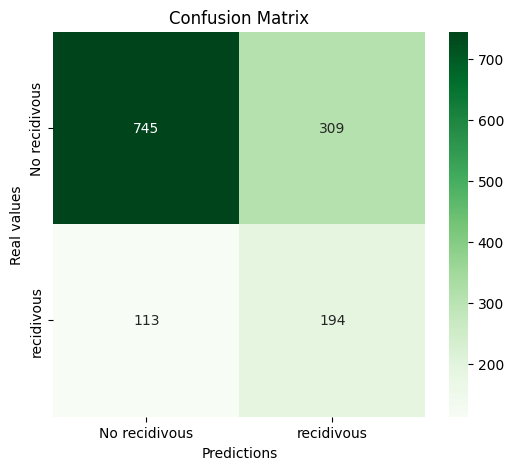

In [ ]:
plot_confusion_matrix(y_test, y_pred_xgb, 'Greens')

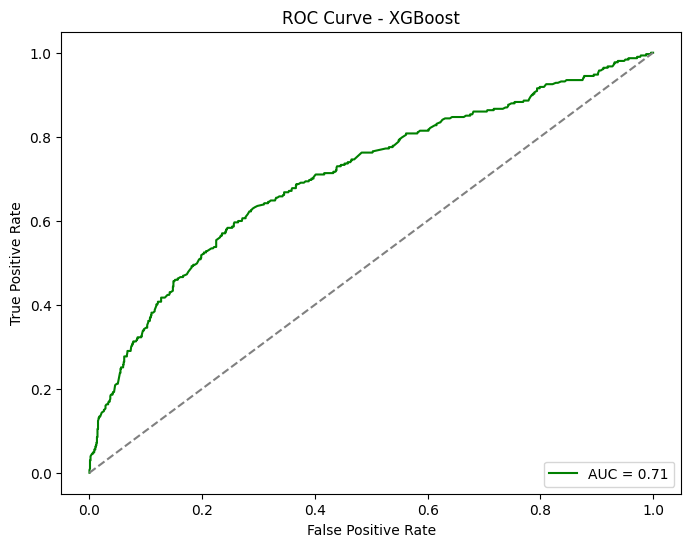

In [ ]:
y_pred_proba = xgb.predict_proba(X_test)[:, 1]
plot_roc_curve(y_test, y_pred_proba, 3)

I harnessed the power of the XGBoost classifier to predict recidivism using a resampled dataset. I initialized the model with specific hyperparameters, including a learning rate of 0.01, a maximum tree depth of 5, and 350 boosting rounds. After training the model on the resampled data, I made predictions on the test dataset. The model achieved an accuracy of 0.69, meaning it correctly predicted 69% of the test cases. Additionally, the Area Under the Curve (AUC) of the Receiver Operating Characteristic (ROC) was 0.71, indicating the model has a reasonable ability to distinguish between the positive and negative classes.

A detailed classification report revealed some interesting insights:

For the "false" class (non-recidivists), the model had a precision of 0.87 and a recall of 0.71. This means that while the model correctly identifies a significant portion of non-recidivists, it has a relatively high false positive rate.
For the "true" class (recidivists), the precision was 0.39, and the recall was 0.63, showing a moderate ability to correctly identify recidivists.

Overall, while the model demonstrates reasonable performance, there's definitely room for improvement, particularly in reducing the false positive rate and enhancing the precision for both classes.

# Models Comparison

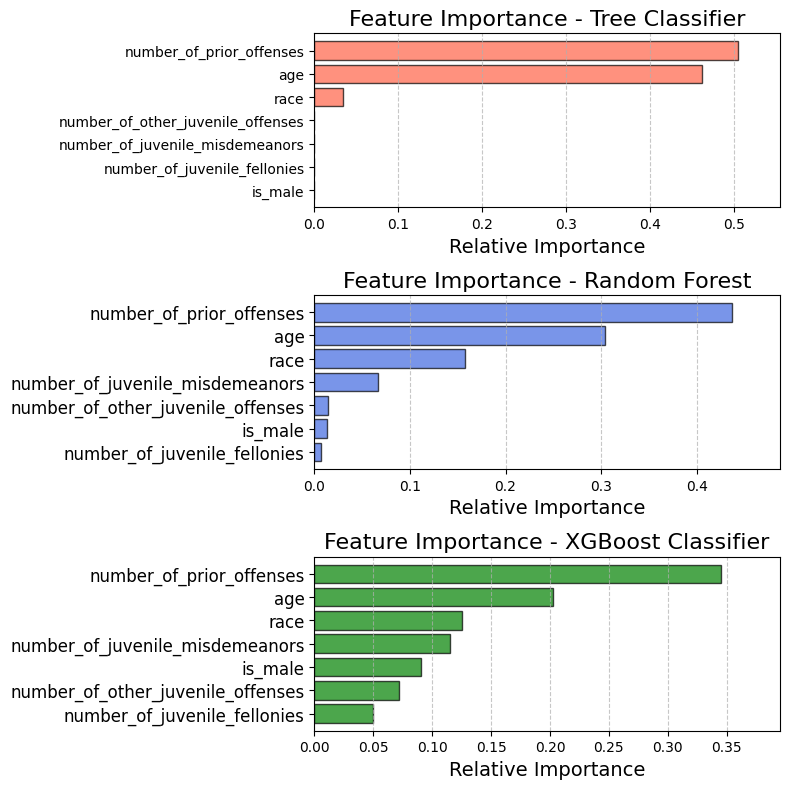

In [ ]:
importances_rf = rf.feature_importances_
indices_rf = importances_rf.argsort()

importances_tree = clf_tree.feature_importances_
indices_tree = importances_tree.argsort()

importances_xgb = xgb.feature_importances_
indices_xgb = importances_xgb.argsort()

plt.figure(figsize=(8, 8))

plt.subplot(3, 1, 1)
plt.title('Feature Importance - Tree Classifier', fontsize=16)
plt.barh(range(len(indices_tree)), importances_tree[indices_tree], color='tomato', align='center', edgecolor='black', alpha=0.7)
plt.yticks(range(len(indices_tree)), [features[i] for i in indices_tree], fontsize=10)
plt.xlabel('Relative Importance', fontsize=14)
plt.xlim(0, max(importances_tree) + 0.05)
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.subplot(3, 1, 2)
plt.title('Feature Importance - Random Forest', fontsize=16)
plt.barh(range(len(indices_rf)), importances_rf[indices_rf], color='royalblue', align='center', edgecolor='black', alpha=0.7)
plt.yticks(range(len(indices_rf)), [features[i] for i in indices_rf], fontsize=12)
plt.xlabel('Relative Importance', fontsize=14)
plt.xlim(0, max(importances_rf) + 0.05)
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.subplot(3, 1, 3)
plt.title('Feature Importance - XGBoost Classifier', fontsize=16)
plt.barh(range(len(indices_xgb)), importances_xgb[indices_xgb], color='green', align='center', edgecolor='black', alpha=0.7)
plt.yticks(range(len(indices_xgb)), [features[i] for i in indices_xgb], fontsize=12)
plt.xlabel('Relative Importance', fontsize=14)
plt.xlim(0, max(importances_xgb) + 0.05)
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

The comparative analysis of feature importance across different classifiers provides valuable insights into which features are most predictive of recidivism. While "number_of_prior_offenses" and "age" are consistently important, the relative importance of other features can vary depending on the classifier used. This information can guide further feature engineering and model selection for improving predictive performance. Notably, the XGBoost Classifier highlights the importance of race more prominently compared to the Tree Classifier and Random Forest, suggesting that this feature might be more effectively captured by the XGBoost model.

# Bias Examination

In [ ]:
!pip install aif360

In [ ]:
from aif360.datasets import StandardDataset
from aif360.metrics import ClassificationMetric
import warnings
warnings.filterwarnings('ignore')

In [ ]:
def bias_examination(name, colors):
  tpr_black = classification_metric.true_positive_rate_difference()
  fpr_black = classification_metric.false_positive_rate_difference()
  ppr_black = classification_metric.statistical_parity_difference()
  metrics_black_vs_nonblack = {
      'True Positive Rate Difference': tpr_black,
      'False Positive Rate Difference': fpr_black,
      'Predicted Positive Rate Difference': ppr_black
  }
  f = plt.figure(figsize=(10, 6))
  bars = plt.bar(metrics_black_vs_nonblack.keys(), metrics_black_vs_nonblack.values(), color=colors)
  for bar in bars:
      yval = bar.get_height()
      plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.2f}', ha='center', va='bottom')
  plt.title(name)
  plt.xlabel("Metric")
  plt.ylabel("Difference in Metric Value (Black vs. Non-Black)")
  plt.axhline(0, color='black', linewidth=0.8)
  plt.savefig(name)
  plt.close(f)

**Metrics Interpretation**

*Disparate Impact*
 - **Acceptable Fairness Range**: A value between 0.8 and 1.25.

*Demographic Parity Difference*
 - **Interpretation**:
   - Positive values suggest privilege for the privileged groups.
   - Negative values suggest privilege for the unprivileged groups.
 - **Desirable Values**: Values close to 0 are desirable.

*Equal Opportunity Difference*
 - **Purpose**: Measures whether the unprivileged group has equal access to favorable outcomes compared to the privileged group.
  - **Desirable Values**: Values close to 0 are desirable.

*Average Odds Difference*
 - **Calculation**: Averages both true positive and false positive disparities.
 - **Desirable Values**: Values close to 0 are desirable, indicating minimal disparity.


**Tree classifier analysis**

*Tree without resampling*

In [ ]:
df['race'] = df['race'].replace({'Black': 0, 'Caucasian': 1, 'Hispanic': 2, 'Other': 3, 'Asian': 4, 'Native American': 5})

features = ['age', 'is_male', 'number_of_juvenile_fellonies', 'number_of_juvenile_misdemeanors',
            'number_of_other_juvenile_offenses', 'number_of_prior_offenses']
target = 'is_recidivous'

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

y_test_with_race = df.loc[y_test.index, ['race']].reset_index(drop=True)
X_test_with_race = pd.concat([X_test.reset_index(drop=True), y_test_with_race], axis=1)

tree_clf = DecisionTreeClassifier(max_depth=5, random_state=42)

tree_clf.fit(X_train, y_train)

y_pred = tree_clf.predict(X_test)

test_dataset = StandardDataset(pd.concat([X_test_with_race, y_test.reset_index(drop=True)], axis=1),
                                   label_name='is_recidivous', favorable_classes=[0],
                                   protected_attribute_names=['race'],
                                   privileged_classes=[[1, 2, 3, 4, 5]])  # Exclude 'African American'

predicted_test_dataset = test_dataset.copy(deepcopy=True)
predicted_test_dataset.labels = y_pred

classification_metric = ClassificationMetric(test_dataset, predicted_test_dataset,
                                             privileged_groups=[{'race': 1}, {'race': 2}, {'race': 3}, {'race': 4}, {'race': 5}],
                                             unprivileged_groups=[{'race': 0}])

print(f'Disparate Impact: {classification_metric.disparate_impact():.2f}')
print(f'Demographic Parity Difference: {classification_metric.mean_difference():.2f}')
print(f'Equal Opportunity Difference: {classification_metric.equal_opportunity_difference():.3f}')
print(f'Average Odds Difference: {classification_metric.average_odds_difference():.3f}')
bias_examination("Tree without resampling", ['navajowhite', 'darkorange', 'chocolate'])

Disparate Impact: 2.55
Demographic Parity Difference: 0.06
Equal Opportunity Difference: 0.036
Average Odds Difference: 0.044


*Tree using resampling*

In [ ]:
features = ['age', 'is_male', 'number_of_juvenile_fellonies', 'number_of_juvenile_misdemeanors',
            'number_of_other_juvenile_offenses', 'number_of_prior_offenses']
target = 'is_recidivous'

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

smote = SMOTE(sampling_strategy='minority', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

y_test_with_race = df.loc[y_test.index, ['race']].reset_index(drop=True)
X_test_with_race = pd.concat([X_test.reset_index(drop=True), y_test_with_race], axis=1)

tree_clf = DecisionTreeClassifier(max_depth=5, random_state=42)

tree_clf.fit(X_train_resampled, y_train_resampled)

y_pred = tree_clf.predict(X_test)

test_dataset = StandardDataset(
    pd.concat([X_test_with_race, y_test.reset_index(drop=True)], axis=1),
    label_name='is_recidivous', favorable_classes=[0],
    protected_attribute_names=['race'],
    privileged_classes=[[1, 2, 3, 4, 5]]
)

predicted_test_dataset = test_dataset.copy(deepcopy=True)
predicted_test_dataset.labels = y_pred

classification_metric = ClassificationMetric(
    test_dataset, predicted_test_dataset,
    privileged_groups=[{'race': 1}, {'race': 2}, {'race': 3}, {'race': 4}, {'race': 5}],
    unprivileged_groups=[{'race': 0}]
)

print(f'Disparate Impact: {classification_metric.disparate_impact():.2f}')
print(f'Demographic Parity Difference: {classification_metric.mean_difference():.2f}')
print(f'Equal Opportunity Difference: {classification_metric.equal_opportunity_difference():.3f}')
print(f'Average Odds Difference: {classification_metric.average_odds_difference():.3f}')
bias_examination("Tree with resampling", ['navajowhite', 'darkorange', 'chocolate'])

Disparate Impact: 2.12
Demographic Parity Difference: 0.24
Equal Opportunity Difference: 0.184
Average Odds Difference: 0.216


**Random forest analysis**

In [ ]:
df['race'] = df['race'].replace({'Black': 0, 'Caucasian': 1, 'Hispanic': 2, 'Other': 3, 'Asian': 4, 'Native American': 5})

features = ['age', 'is_male', 'number_of_juvenile_fellonies', 'number_of_juvenile_misdemeanors',
            'number_of_other_juvenile_offenses', 'number_of_prior_offenses']
target = 'is_recidivous'

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

y_test_with_race = df.loc[y_test.index, ['race']].reset_index(drop=True)
X_test_with_race = pd.concat([X_test.reset_index(drop=True), y_test_with_race], axis=1)

rf = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42, max_leaf_nodes=35)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

test_dataset = StandardDataset(pd.concat([X_test_with_race, y_test.reset_index(drop=True)], axis=1),
                                   label_name='is_recidivous', favorable_classes=[0],
                                   protected_attribute_names=['race'],
                                   privileged_classes=[[1, 2, 3, 4, 5]])  # Exclude 'African American'

predicted_test_dataset = test_dataset.copy(deepcopy=True)
predicted_test_dataset.labels = y_pred

classification_metric = ClassificationMetric(test_dataset, predicted_test_dataset,
                                             privileged_groups=[{'race': 1}, {'race': 2}, {'race': 3}, {'race': 4}, {'race': 5}],
                                             unprivileged_groups=[{'race': 0}])

print(f'Disparate Impact: {classification_metric.disparate_impact():.2f}')
print(f'Demographic Parity Difference: {classification_metric.mean_difference():.2f}')
print(f'Equal Opportunity Difference: {classification_metric.equal_opportunity_difference():.3f}')
print(f'Average Odds Difference: {classification_metric.average_odds_difference():.3f}')
bias_examination("Forest without resampling", ['lightskyblue', 'dodgerblue', 'blue'])

Disparate Impact: 3.41
Demographic Parity Difference: 0.02
Equal Opportunity Difference: 0.012
Average Odds Difference: 0.030


In [ ]:
features = ['age', 'is_male', 'number_of_juvenile_fellonies', 'number_of_juvenile_misdemeanors',
            'number_of_other_juvenile_offenses', 'number_of_prior_offenses']
target = 'is_recidivous'

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
smote = SMOTE(sampling_strategy='minority', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

y_test_with_race = df.loc[y_test.index, ['race']].reset_index(drop=True)
X_test_with_race = pd.concat([X_test.reset_index(drop=True), y_test_with_race], axis=1)

rf = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42, max_leaf_nodes=35)

rf.fit(X_train_resampled, y_train_resampled)

y_pred = rf.predict(X_test)

test_dataset = StandardDataset(
    pd.concat([X_test_with_race, y_test.reset_index(drop=True)], axis=1),
    label_name='is_recidivous', favorable_classes=[0],
    protected_attribute_names=['race'],
    privileged_classes=[[1, 2, 3, 4, 5]]
)

predicted_test_dataset = test_dataset.copy(deepcopy=True)
predicted_test_dataset.labels = y_pred

classification_metric = ClassificationMetric(
    test_dataset, predicted_test_dataset,
    privileged_groups=[{'race': 1}, {'race': 2}, {'race': 3}, {'race': 4}, {'race': 5}],
    unprivileged_groups=[{'race': 0}]
)

print(f'Disparate Impact: {classification_metric.disparate_impact():.2f}')
print(f'Demographic Parity Difference: {classification_metric.mean_difference():.2f}')
print(f'Equal Opportunity Difference: {classification_metric.equal_opportunity_difference():.3f}')
print(f'Average Odds Difference: {classification_metric.average_odds_difference():.3f}')
bias_examination("Forest with resampling", ['lightskyblue', 'dodgerblue', 'blue'])

Disparate Impact: 2.03
Demographic Parity Difference: 0.26
Equal Opportunity Difference: 0.201
Average Odds Difference: 0.232


**XGBoost analysis**

In [ ]:
import xgboost as xgb
df['race'] = df['race'].replace({'Black': 0, 'Caucasian': 1, 'Hispanic': 2, 'Other': 3, 'Asian': 4, 'Native American': 5})

features = ['age', 'is_male', 'number_of_juvenile_fellonies', 'number_of_juvenile_misdemeanors',
            'number_of_other_juvenile_offenses', 'number_of_prior_offenses']
target = 'is_recidivous'

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

y_test_with_race = df.loc[y_test.index, ['race']].reset_index(drop=True)
X_test_with_race = pd.concat([X_test.reset_index(drop=True), y_test_with_race], axis=1)

xgb = xgb.XGBClassifier(learning_rate= 0.01, max_depth= 5, n_estimators= 350, scale_pos_weight=1, random_state=42)

xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)
test_dataset = StandardDataset(pd.concat([X_test_with_race, y_test.reset_index(drop=True)], axis=1),
                                   label_name='is_recidivous', favorable_classes=[0],
                                   protected_attribute_names=['race'],
                                   privileged_classes=[[1, 2, 3, 4, 5]])  # Exclude 'African American'
predicted_test_dataset = test_dataset.copy(deepcopy=True)
predicted_test_dataset.labels = y_pred

classification_metric = ClassificationMetric(test_dataset, predicted_test_dataset,
                                             privileged_groups=[{'race': 1}, {'race': 2}, {'race': 3}, {'race': 4}, {'race': 5}],
                                             unprivileged_groups=[{'race': 0}])

print(f'Disparate Impact: {classification_metric.disparate_impact():.2f}')
print(f'Demographic Parity Difference: {classification_metric.mean_difference():.2f}')
print(f'Equal Opportunity Difference: {classification_metric.equal_opportunity_difference():.3f}')
print(f'Average Odds Difference: {classification_metric.average_odds_difference():.3f}')
bias_examination("xgb without resampling", ['palegreen', 'seagreen', 'darkgreen'])

Disparate Impact: 2.79
Demographic Parity Difference: 0.08
Equal Opportunity Difference: 0.052
Average Odds Difference: 0.068


In [ ]:
import xgboost as xgb
features = ['age', 'is_male', 'number_of_juvenile_fellonies', 'number_of_juvenile_misdemeanors',
            'number_of_other_juvenile_offenses', 'number_of_prior_offenses']
target = 'is_recidivous'

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

smote = SMOTE(sampling_strategy='minority', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

y_test_with_race = df.loc[y_test.index, ['race']].reset_index(drop=True)
X_test_with_race = pd.concat([X_test.reset_index(drop=True), y_test_with_race], axis=1)

xgb = xgb.XGBClassifier(learning_rate= 0.01, max_depth= 5, n_estimators= 350, scale_pos_weight=1, random_state=42)

xgb.fit(X_train_resampled, y_train_resampled)

y_pred = xgb.predict(X_test)

test_dataset = StandardDataset(
    pd.concat([X_test_with_race, y_test.reset_index(drop=True)], axis=1),
    label_name='is_recidivous', favorable_classes=[0],
    protected_attribute_names=['race'],
    privileged_classes=[[1, 2, 3, 4, 5]]
)

predicted_test_dataset = test_dataset.copy(deepcopy=True)
predicted_test_dataset.labels = y_pred

classification_metric = ClassificationMetric(
    test_dataset, predicted_test_dataset,
    privileged_groups=[{'race': 1}, {'race': 2}, {'race': 3}, {'race': 4}, {'race': 5}],
    unprivileged_groups=[{'race': 0}]
)

print(f'Disparate Impact: {classification_metric.disparate_impact():.2f}')
print(f'Demographic Parity Difference: {classification_metric.mean_difference():.2f}')
print(f'Equal Opportunity Difference: {classification_metric.equal_opportunity_difference():.3f}')
print(f'Average Odds Difference: {classification_metric.average_odds_difference():.3f}')
bias_examination("xgb with resampling", ['palegreen', 'seagreen', 'darkgreen'])

Disparate Impact: 2.10
Demographic Parity Difference: 0.24
Equal Opportunity Difference: 0.183
Average Odds Difference: 0.235


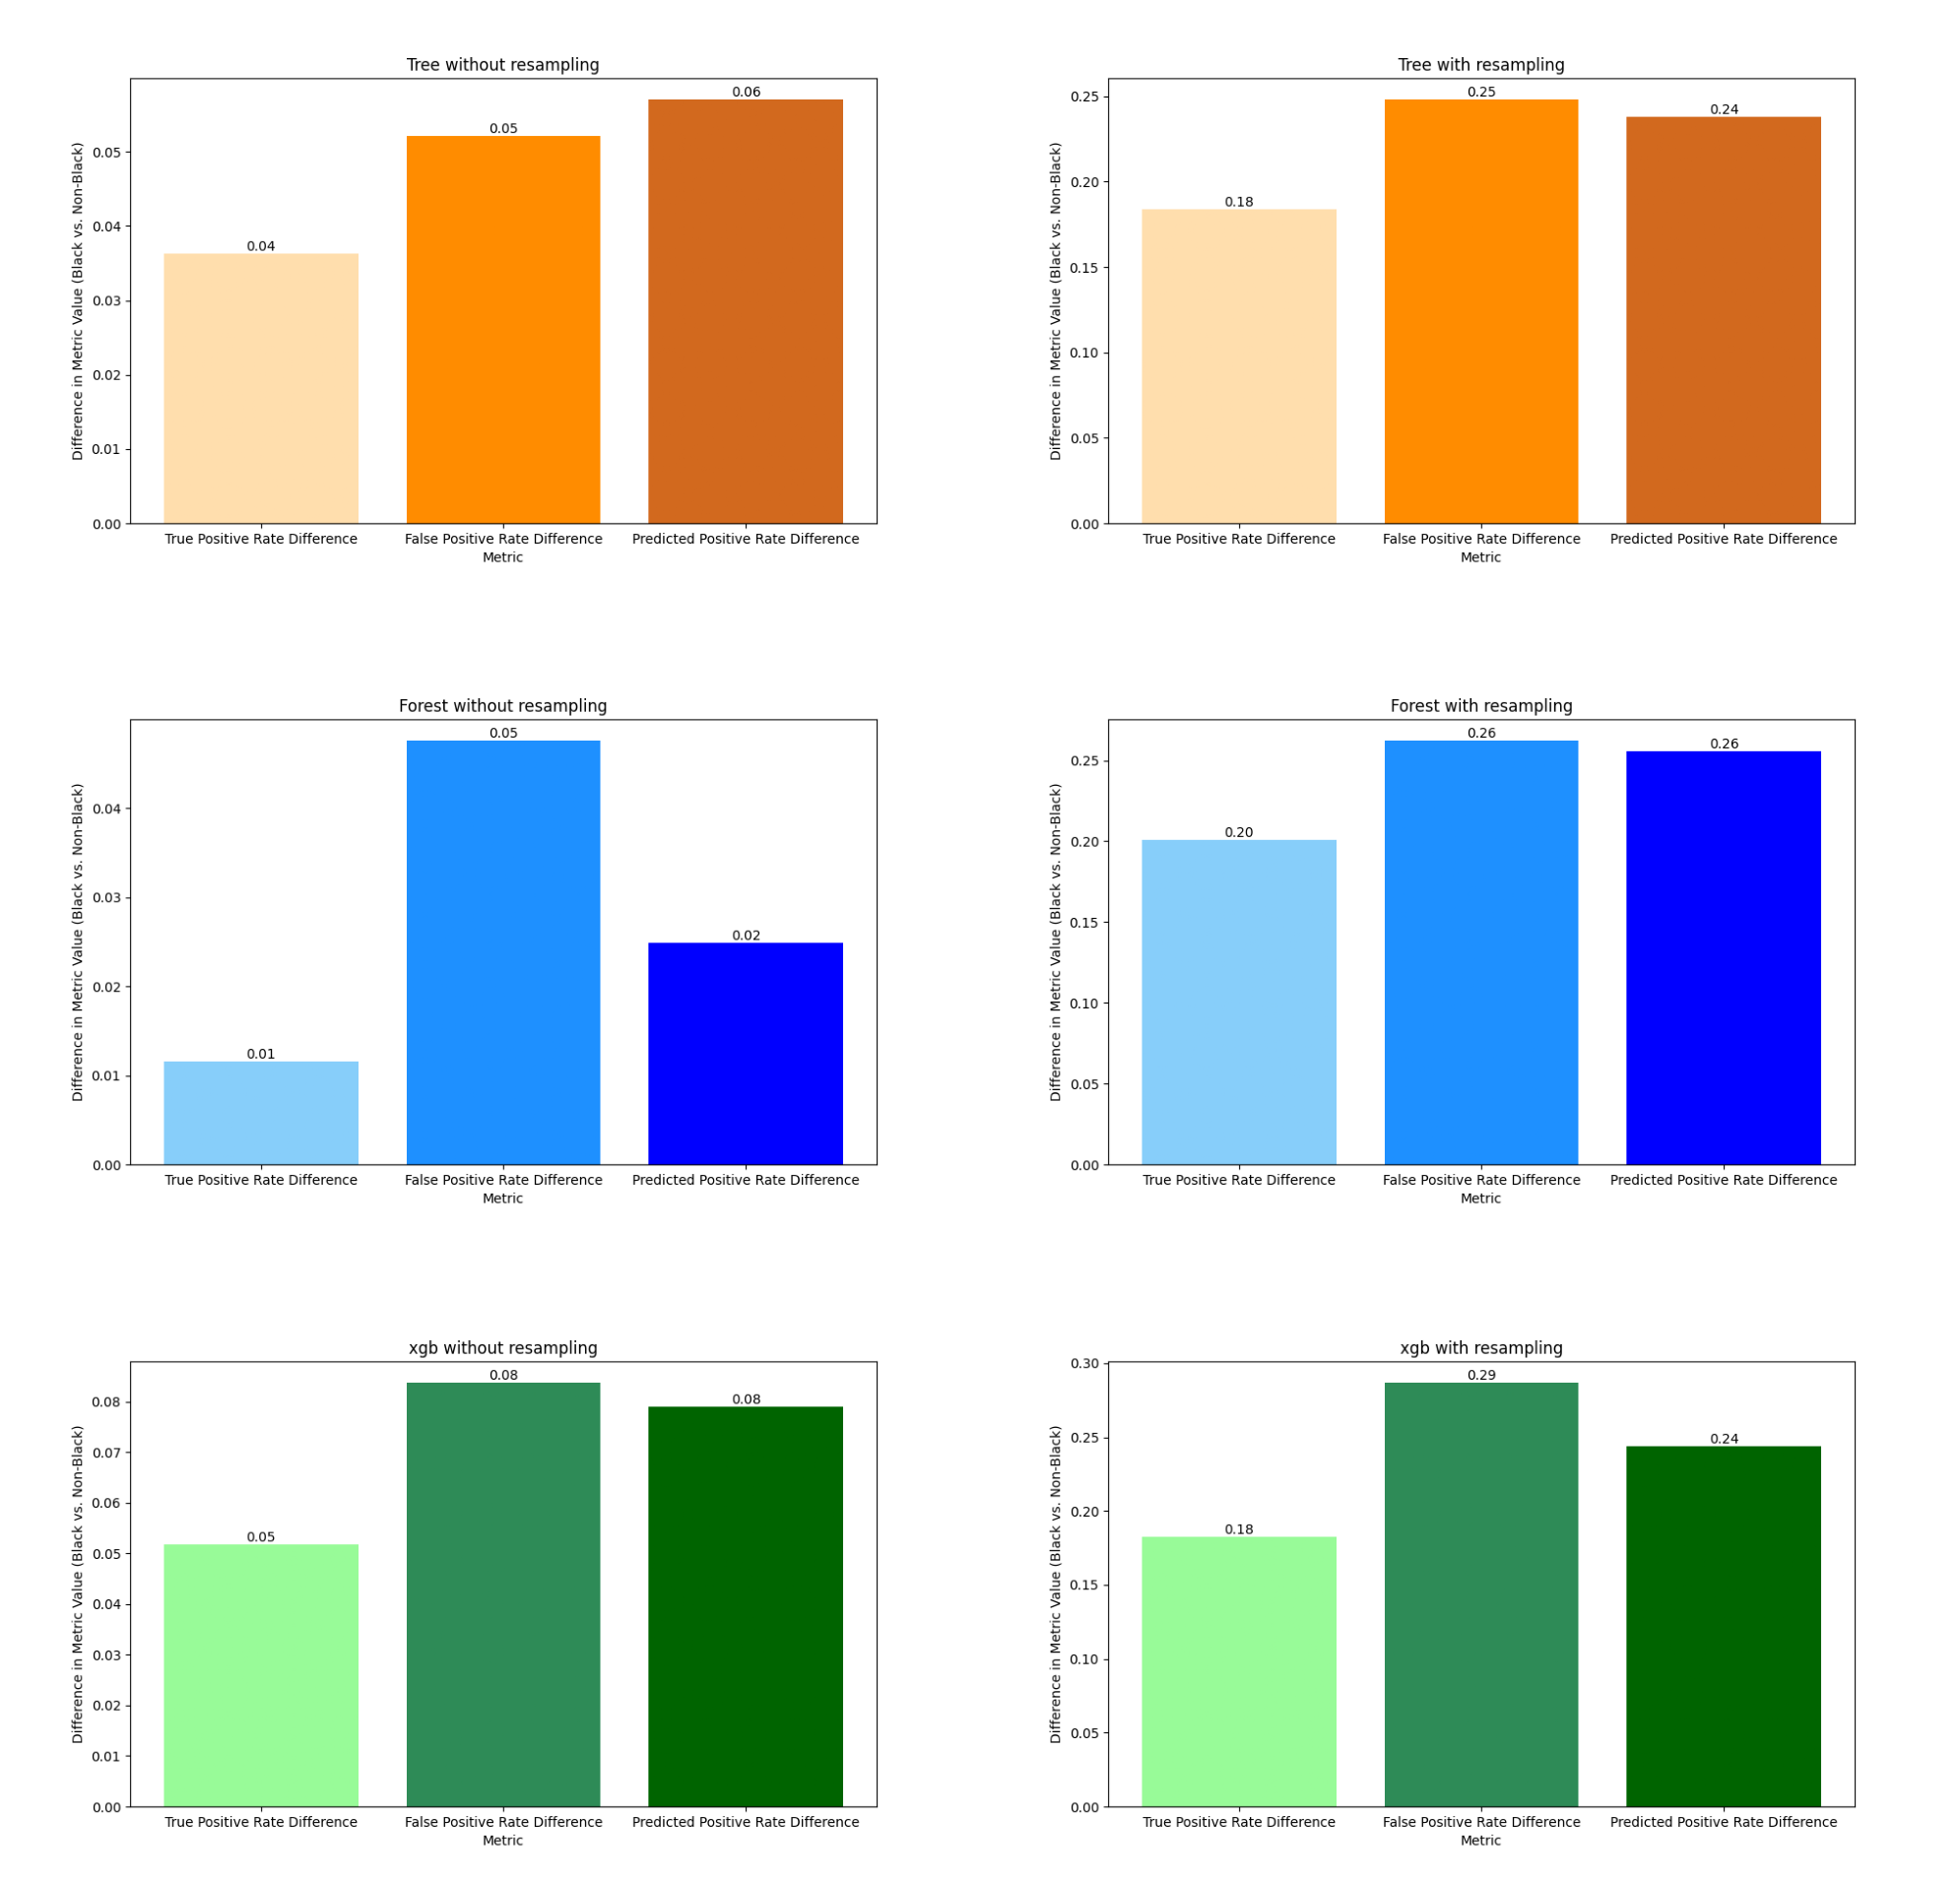

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(20, 20))

img1 = mpimg.imread('Tree without resampling.png')
axes[0, 0].imshow(img1)
axes[0, 0].axis('off')
img2 = mpimg.imread('Tree with resampling.png')
axes[0, 1].imshow(img2)
axes[0, 1].axis('off')
img3 = mpimg.imread('Forest without resampling.png')
axes[1, 0].imshow(img3)
axes[1, 0].axis('off')
img4 = mpimg.imread('Forest with resampling.png')
axes[1, 1].imshow(img4)
axes[1, 1].axis('off')
img5 = mpimg.imread('xgb without resampling.png')
axes[2, 0].imshow(img5)
axes[2, 0].axis('off')
img6 = mpimg.imread('xgb with resampling.png')
axes[2, 1].imshow(img6)
axes[2, 1].axis('off')

plt.tight_layout()
plt.show()

The comparison of models with and without resampling techniques reveals significant insights into their performance and fairness. While resampling techniques such as SMOTE help in balancing the class distribution and reducing bias to some extent, the models still exhibit disparities in predictions across different racial groups.

**Tree Classifier**: The application of resampling reduced the disparate impact **from 2.55 to 2.12**, indicating a slight improvement in fairness. However, the demographic parity and equal opportunity differences increased, suggesting some trade-offs in fairness metrics.

**Random Forest Classifier**: Resampling reduced the disparate impact significantly **from 3.41 to 2.03**, indicating a substantial improvement in fairness. However, the demographic parity and equal opportunity differences increased, suggesting some trade-offs in fairness metrics.

**XGBoost Classifier**: Resampling reduced the disparate impact **from 2.79 to 2.10**, indicating a moderate improvement in fairness. The demographic parity and equal opportunity differences increased, suggesting some trade-offs in fairness metrics.

# Ethical Considerations of Including Race as a Feature

Including race as a feature in predictive models can lead to several ethical and practical issues, primarily because it can induce and perpetuate racist biases. Here’s an explanation of why maintaining race as a feature is generally not advisable:

## Ethical Concerns
1. **Perpetuation of Bias:** Including race in a model can reinforce existing biases and inequalities. Historical and systemic biases are often reflected in data, and using race as a predictor can amplify these biases in the model's predictions.
2. **Discrimination:** Models that use race as a feature can lead to discriminatory outcomes. For instance, a recidivism prediction model might incorrectly predict higher rates of recidivism for certain racial groups, leading to unfair treatment in the criminal justice system.
3. **Privacy and Fairness:** Including sensitive attributes like race can raise privacy concerns and violate principles of fairness. Individuals may not want their race to influence decisions made about them, and including it can lead to unfair outcomes.

## Practical Concerns
1. **Overfitting:** Race might become a proxy for other socioeconomic factors that are correlated with race. This can lead to overfitting, where the model performs well on the training data but poorly on new, unseen data.
2. **Legal and Regulatory Issues:** Many jurisdictions have laws and regulations that prohibit the use of race in decision-making processes. Including race as a feature can put an organization at risk of legal penalties and reputational damage.
3. **Lack of Generalizability:** Models that include race may not generalize well to diverse populations. A model trained on a dataset with a particular racial composition may perform poorly when applied to a different racial group.

## Alternative Approaches
1. **Feature Engineering:** Instead of using race directly, consider using features that are correlated with race but are less likely to introduce bias.
2. **Bias Mitigation Techniques:** Use techniques such as pre-processing (e.g., reweighting the data), in-processing (e.g., adding fairness constraints), and post-processing (e.g., adjusting predictions) to mitigate bias.
3. **Fairness Metrics:** Evaluate models using fairness metrics to ensure that predictions are equitable across different groups. This can help identify and address biases in the model.

## Conclusion
Maintaining race as a feature in predictive models can induce and perpetuate racist biases, leading to unfair and discriminatory outcomes. It is essential to consider ethical implications, legal constraints, and practical concerns when deciding whether to include race as a feature. Alternative approaches and bias mitigation techniques can help create more fair and equitable models.

By adopting these practices, we can strive to build models that are not only accurate but also fair and respectful of individual rights and societal values.


# **Random Forest without ethnicity**

Accuracy: 0.96
              precision    recall  f1-score   support

       False       0.96      1.00      0.98      1054
        True       0.98      0.85      0.91       307

    accuracy                           0.96      1361
   macro avg       0.97      0.92      0.94      1361
weighted avg       0.96      0.96      0.96      1361



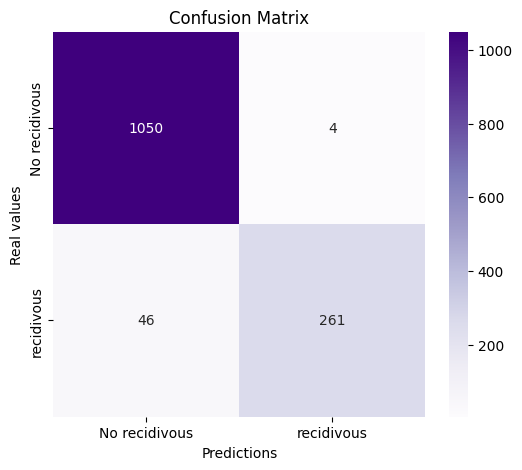

In [ ]:
data = load_dataset("mstz/compas", "two-years-recidividity")["train"]
data = data.to_pandas()
data['total_juvenile_offenses'] = data['number_of_juvenile_fellonies'] + data['number_of_juvenile_misdemeanors']
data = data.drop(['number_of_juvenile_fellonies', 'number_of_juvenile_misdemeanors'], axis=1)

X = data.drop('is_recidivous', axis=1)
y = data['is_recidivous']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define preprocessing for numeric columns (scale them) and categorical columns (one-hot encode them)
numeric_features = ['age', 'decile_score', 'number_of_other_juvenile_offenses', 'number_of_prior_offenses', 'days_before_screening_arrest', 'days_in_custody', 'violence_decile_score']
categorical_features = ['is_male', 'is_violent_recidivous', 'two_year_recidivous']

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Append classifier to preprocessing pipeline.
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier(class_weight='balanced'))])

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test, y_pred))
plot_confusion_matrix(y_test, y_pred, 'Purples')

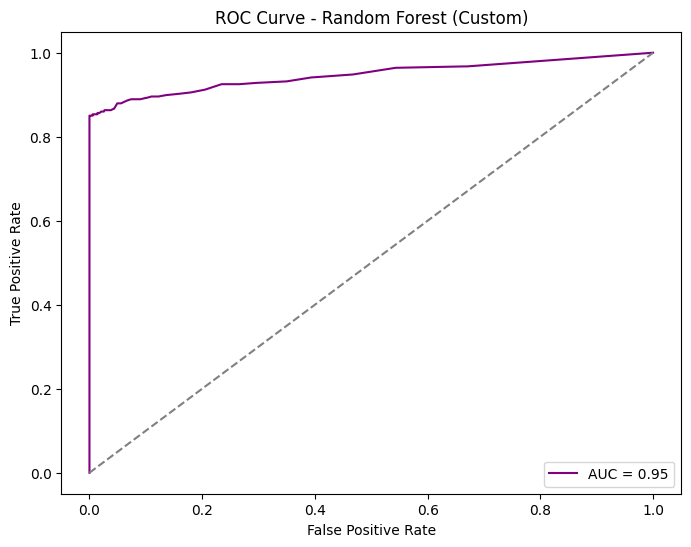

In [ ]:
y_pred_proba = clf.predict_proba(X_test)[:, 1]
plot_roc_curve(y_test, y_pred_proba, 4)

Diving into the classification report, here’s what I found:

For the non-recidivism class (False), the model nailed a precision of 0.96 and a recall of 1.00, showing it’s excellent at spotting cases of non-recidivism with almost no false negatives.
For the recidivism class (True), the precision came in at 0.98, and the recall at 0.85.

The confusion matrix backs this up, revealing 1050 true negatives, 4 false positives, 46 false negatives, and 261 true positives. This indicates a clear strength in accurately predicting non-recidivism cases but highlights the need to better identify recidivism cases.

The model’s high accuracy and balanced precision and recall for both classes suggest it has a strong ability to distinguish between the two classes without using race as a feature.